In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/-266_jpg.rf.bab0e56a2f62e119c85f3be48ca7acd2_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/0218092217_jpg.rf.ebd2647e23cbd4ca9c48d05acf070358_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/bottle-173-_JPG_jpg.rf.40d7a867bd935c6c1c33b0a26bd26639_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/bottle-684-_JPG_jpg.rf.871159abb926fdbc8363b359231d9e4a_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/000457_jpg.rf.31568ccf2ea0512c3022b63a651a3012_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/5bottlewater_png_jpg.rf.573480210eeacfd613060ec0cc29b48c_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/000412_jpg.rf.72e4fa63bab18a368a3ddf09fb32eb65_bg0.jpg
/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2/val/not_bottle/000332_jp

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [3]:
# Configuration
data_dir = "/kaggle/input/resnet-bottle-classifier-2/dataset_resnet2"
model_save_path = "resnet_classifier.pth"
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
# Load model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


In [5]:
# Helper function to evaluate
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

In [6]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")

    # === Validation Accuracy ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct/total:.4f}")

Epoch 1: 100%|██████████| 61/61 [00:14<00:00,  4.18it/s]


Epoch [1/10] Loss: 0.3764
Validation Accuracy: 0.8971


Epoch 2: 100%|██████████| 61/61 [00:07<00:00,  8.13it/s]


Epoch [2/10] Loss: 0.2188
Validation Accuracy: 0.9177


Epoch 3: 100%|██████████| 61/61 [00:07<00:00,  8.50it/s]


Epoch [3/10] Loss: 0.1706
Validation Accuracy: 0.9218


Epoch 4: 100%|██████████| 61/61 [00:07<00:00,  8.70it/s]


Epoch [4/10] Loss: 0.1578
Validation Accuracy: 0.9342


Epoch 5: 100%|██████████| 61/61 [00:07<00:00,  8.60it/s]


Epoch [5/10] Loss: 0.1424
Validation Accuracy: 0.9383


Epoch 6: 100%|██████████| 61/61 [00:07<00:00,  8.24it/s]


Epoch [6/10] Loss: 0.1364
Validation Accuracy: 0.9383


Epoch 7: 100%|██████████| 61/61 [00:07<00:00,  8.37it/s]


Epoch [7/10] Loss: 0.1345
Validation Accuracy: 0.9424


Epoch 8: 100%|██████████| 61/61 [00:07<00:00,  8.65it/s]


Epoch [8/10] Loss: 0.1178
Validation Accuracy: 0.9424


Epoch 9: 100%|██████████| 61/61 [00:07<00:00,  8.36it/s]


Epoch [9/10] Loss: 0.1083
Validation Accuracy: 0.9424


Epoch 10: 100%|██████████| 61/61 [00:07<00:00,  8.36it/s]


Epoch [10/10] Loss: 0.1048
Validation Accuracy: 0.9465



Classification Report:
               precision    recall  f1-score   support

      bottle       0.93      0.98      0.96       145
  not_bottle       0.97      0.90      0.93        98

    accuracy                           0.95       243
   macro avg       0.95      0.94      0.94       243
weighted avg       0.95      0.95      0.95       243



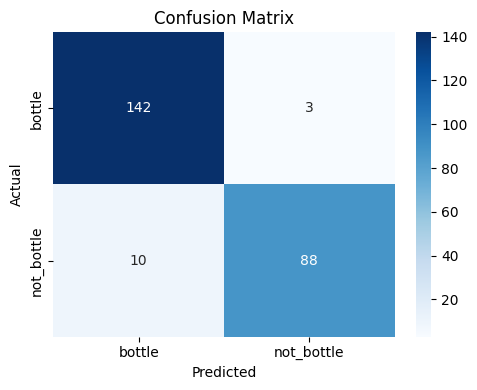

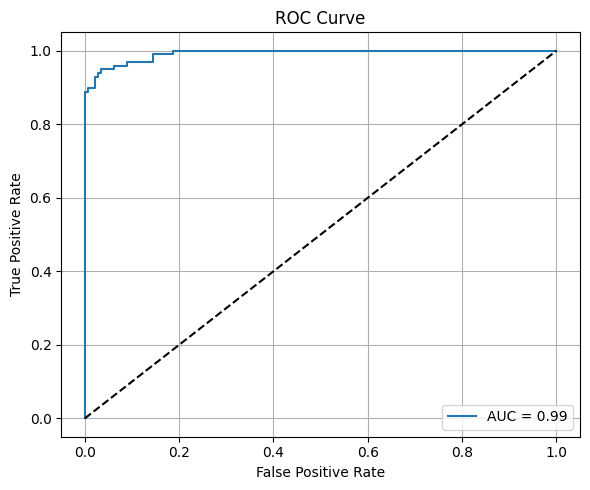

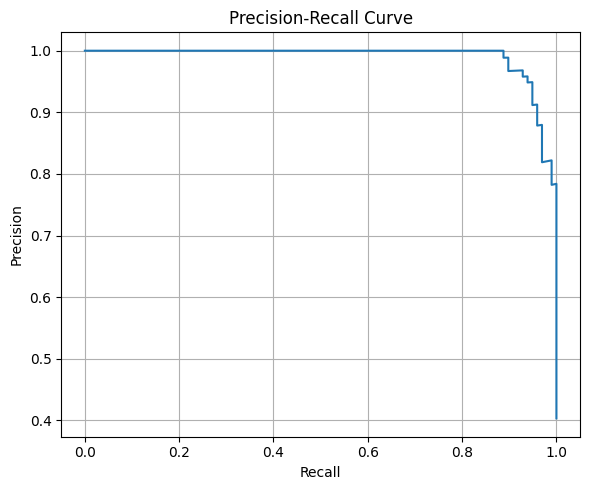

In [7]:
# Evaluate on validation set
y_true, y_pred, y_probs = evaluate(model, val_loader)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

      bottle       0.94      0.99      0.96       145
  not_bottle       0.98      0.91      0.94        98

    accuracy                           0.95       243
   macro avg       0.96      0.95      0.95       243
weighted avg       0.96      0.95      0.95       243



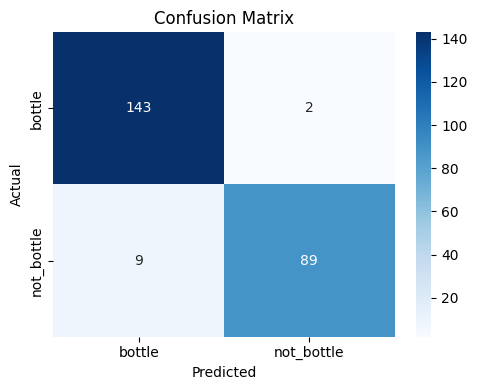

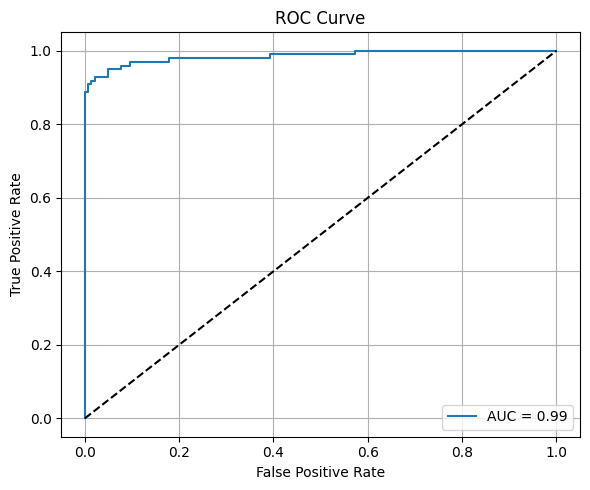

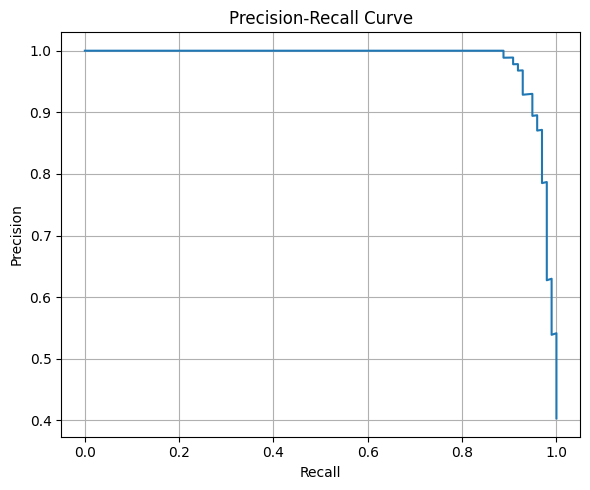

In [ ]:
# Evaluate on test set
y_true, y_pred, y_probs = evaluate(model, test_loader)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(), "resnet18_weights.pth")